In [ ]:
# Gerekli kütüphanelerin yüklenmesi
!pip install scikit-learn tensorflow keras pandas numpy matplotlib seaborn
!wget https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip
!unzip -q GTSRB_Final_Training_Images.zip

--2024-11-27 19:47:58--  https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip
Resolving sid.erda.dk (sid.erda.dk)... 130.225.104.13
Connecting to sid.erda.dk (sid.erda.dk)|130.225.104.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 276294756 (263M) [application/zip]
Saving to: ‘GTSRB_Final_Training_Images.zip’

GTSRB_Final_Trainin 100%[===================>] 263.50M  19.1MB/s    in 15s     

2024-11-27 19:48:14 (17.7 MB/s) - ‘GTSRB_Final_Training_Images.zip’ saved [276294756/276294756]



In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Layer, Dense
from tensorflow.keras.optimizers import Adam
import os
import cv2
from scipy.stats import randint, uniform

In [ ]:
class RBFLayer(Layer):
    def __init__(self, units, gamma=1.0, **kwargs):
        super(RBFLayer, self).__init__(**kwargs)
        self.units = units
        self.gamma = K.cast_to_floatx(gamma)

    def build(self, input_shape):
        self.centers = self.add_weight(
            name='centers',
            shape=(self.units, input_shape[-1]),
            initializer=keras.initializers.RandomUniform(
                minval=-1.0, maxval=1.0
            ),
            trainable=True
        )
        self.built = True

    def call(self, inputs):
        expanded_inputs = tf.expand_dims(inputs, axis=1)
        expanded_centers = tf.expand_dims(self.centers, axis=0)
        distances = tf.reduce_sum(
            tf.square(expanded_inputs - expanded_centers),
            axis=-1
        )
        return tf.exp(-self.gamma * distances)

In [ ]:
def load_data(data_dir='GTSRB/Final_Training/Images'):
    print("Veri yükleme başladı...")
    images = []
    labels = []

    for class_id in range(43):  # GTSRB has 43 classes
        # 5 haneli formata çevirme
        folder_name = str(class_id).zfill(5)  # örneğin 0 -> '00000'
        class_path = os.path.join(data_dir, folder_name)
        print(f"Sınıf {class_id} yükleniyor... Dizin: {class_path}")

        if not os.path.exists(class_path):
            raise FileNotFoundError(f"Dizin bulunamadı: {class_path}")

        for img_name in os.listdir(class_path):
            if img_name.endswith('.ppm'):
                img_path = os.path.join(class_path, img_name)
                try:
                    img = cv2.imread(img_path)
                    if img is None:
                        print(f"Uyarı: {img_path} okunamadı")
                        continue
                    img = cv2.resize(img, (32, 32))
                    images.append(img.flatten())
                    labels.append(class_id)
                except Exception as e:
                    print(f"Hata: {img_path} işlenirken hata oluştu: {str(e)}")
                    continue

        print(f"Sınıf {class_id} için {len([l for l in labels if l == class_id])} görüntü yüklendi")

    print(f"Toplam {len(images)} görüntü yüklendi")
    return np.array(images), np.array(labels)

In [ ]:
# Model oluşturma fonksiyonları
def create_basic_mlp():
    return MLPClassifier(
        hidden_layer_sizes=(100, 100),
        activation='relu',
        max_iter=300,
        random_state=42
    )

def create_basic_rbf_model(input_dim, num_classes, num_centers=256, gamma=0.005):
    inputs = keras.layers.Input(shape=(input_dim,))

    # Batch Normalization ekledik
    x = keras.layers.BatchNormalization()(inputs)

    # RBF katmanı
    rbf = RBFLayer(num_centers, gamma)(x)

    # Dropout ekledik
    x = keras.layers.Dropout(0.3)(rbf)

    # Daha derin bir mimari
    x = Dense(512, activation='relu')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dropout(0.3)(x)

    x = Dense(256, activation='relu')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dropout(0.2)(x)

    outputs = Dense(num_classes, activation='softmax')(x)

    model = keras.Model(inputs=inputs, outputs=outputs)

    # Learning rate scheduler ekledik
    initial_learning_rate = 0.001
    decay_steps = 1000
    decay_rate = 0.9
    learning_rate_schedule = keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate, decay_steps, decay_rate
    )

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate_schedule),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    print("Model Özeti:")
    model.summary()
    return model


In [ ]:
def detailed_evaluation(y_true, y_pred, model_name):
    """Detaylı model değerlendirme fonksiyonu"""
    print(f"\n{'='*50}")
    print(f"{model_name} için Detaylı Performans Analizi")
    print(f"{'='*50}")

    # Tüm metrikler - zero_division parametresi eklendi
    print("\n1. Temel Metrikler:")
    print(classification_report(y_true, y_pred, zero_division=1))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(15, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{model_name} - Confusion Matrix')
    plt.ylabel('Gerçek Sınıflar')
    plt.xlabel('Tahmin Edilen Sınıflar')
    plt.show()

    # Her sınıf için detaylı metrikler - zero_division parametresi eklendi
    metrics_dict = classification_report(y_true, y_pred, output_dict=True, zero_division=1)

    print("\n2. Her Sınıf için Detaylı Metrikler:")
    metrics_df = pd.DataFrame(columns=['Precision', 'Recall', 'F1-Score', 'Support'])

    for class_id in range(43):
        if str(class_id) in metrics_dict:
            metrics_df.loc[f'Sınıf {class_id}'] = [
                metrics_dict[str(class_id)]['precision'],
                metrics_dict[str(class_id)]['recall'],
                metrics_dict[str(class_id)]['f1-score'],
                metrics_dict[str(class_id)]['support']
            ]

    print(metrics_df)

    # Tahmin edilmeyen sınıfları belirleme
    unpredicted_classes = []
    for class_id in range(43):
        if not any(y_pred == class_id):
            unpredicted_classes.append(class_id)

    if unpredicted_classes:
        print("\nUyarı: Aşağıdaki sınıflar için hiç tahmin yapılmamış:")
        print(unpredicted_classes)

    # Genel performans özeti
    print("\n3. Genel Performans Özeti:")
    print(f"Accuracy: {metrics_dict['accuracy']:.4f}")
    print(f"Macro avg F1-Score: {metrics_dict['macro avg']['f1-score']:.4f}")
    print(f"Weighted avg F1-Score: {metrics_dict['weighted avg']['f1-score']:.4f}")

    # Metrik görselleştirmeleri
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    metrics_df['Precision'].plot(kind='bar')
    plt.title('Sınıf Bazında Precision')
    plt.xticks(rotation=90)

    plt.subplot(1, 3, 2)
    metrics_df['Recall'].plot(kind='bar')
    plt.title('Sınıf Bazında Recall')
    plt.xticks(rotation=90)

    plt.subplot(1, 3, 3)
    metrics_df['F1-Score'].plot(kind='bar')
    plt.title('Sınıf Bazında F1-Score')
    plt.xticks(rotation=90)

    plt.tight_layout()
    plt.show()

    # En iyi ve en kötü performans gösteren sınıflar
    print("\n4. En İyi ve En Kötü Performans Gösteren Sınıflar:")

    best_f1 = metrics_df['F1-Score'].nlargest(5)
    worst_f1 = metrics_df['F1-Score'].nsmallest(5)

    print("\nEn İyi 5 Sınıf (F1-Score):")
    print(best_f1)
    print("\nEn Kötü 5 Sınıf (F1-Score):")
    print(worst_f1)

    # Sınıf dağılımı analizi
    true_dist = pd.Series(y_true).value_counts().sort_index()
    pred_dist = pd.Series(y_pred).value_counts().sort_index()

    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    true_dist.plot(kind='bar')
    plt.title('Gerçek Sınıf Dağılımı')
    plt.xlabel('Sınıf')
    plt.ylabel('Örnek Sayısı')

    plt.subplot(1, 2, 2)
    pred_dist.plot(kind='bar')
    plt.title('Tahmin Edilen Sınıf Dağılımı')
    plt.xlabel('Sınıf')
    plt.ylabel('Örnek Sayısı')

    plt.tight_layout()
    plt.show()

    return metrics_dict

1. Veri yükleme ve ön işleme...
Veri yükleme başladı...
Sınıf 0 yükleniyor... Dizin: GTSRB/Final_Training/Images/00000
Sınıf 0 için 210 görüntü yüklendi
Sınıf 1 yükleniyor... Dizin: GTSRB/Final_Training/Images/00001
Sınıf 1 için 2220 görüntü yüklendi
Sınıf 2 yükleniyor... Dizin: GTSRB/Final_Training/Images/00002
Sınıf 2 için 2250 görüntü yüklendi
Sınıf 3 yükleniyor... Dizin: GTSRB/Final_Training/Images/00003
Sınıf 3 için 1410 görüntü yüklendi
Sınıf 4 yükleniyor... Dizin: GTSRB/Final_Training/Images/00004
Sınıf 4 için 1980 görüntü yüklendi
Sınıf 5 yükleniyor... Dizin: GTSRB/Final_Training/Images/00005
Sınıf 5 için 1860 görüntü yüklendi
Sınıf 6 yükleniyor... Dizin: GTSRB/Final_Training/Images/00006
Sınıf 6 için 420 görüntü yüklendi
Sınıf 7 yükleniyor... Dizin: GTSRB/Final_Training/Images/00007
Sınıf 7 için 1440 görüntü yüklendi
Sınıf 8 yükleniyor... Dizin: GTSRB/Final_Training/Images/00008
Sınıf 8 için 1410 görüntü yüklendi
Sınıf 9 yükleniyor... Dizin: GTSRB/Final_Training/Images/00009
S

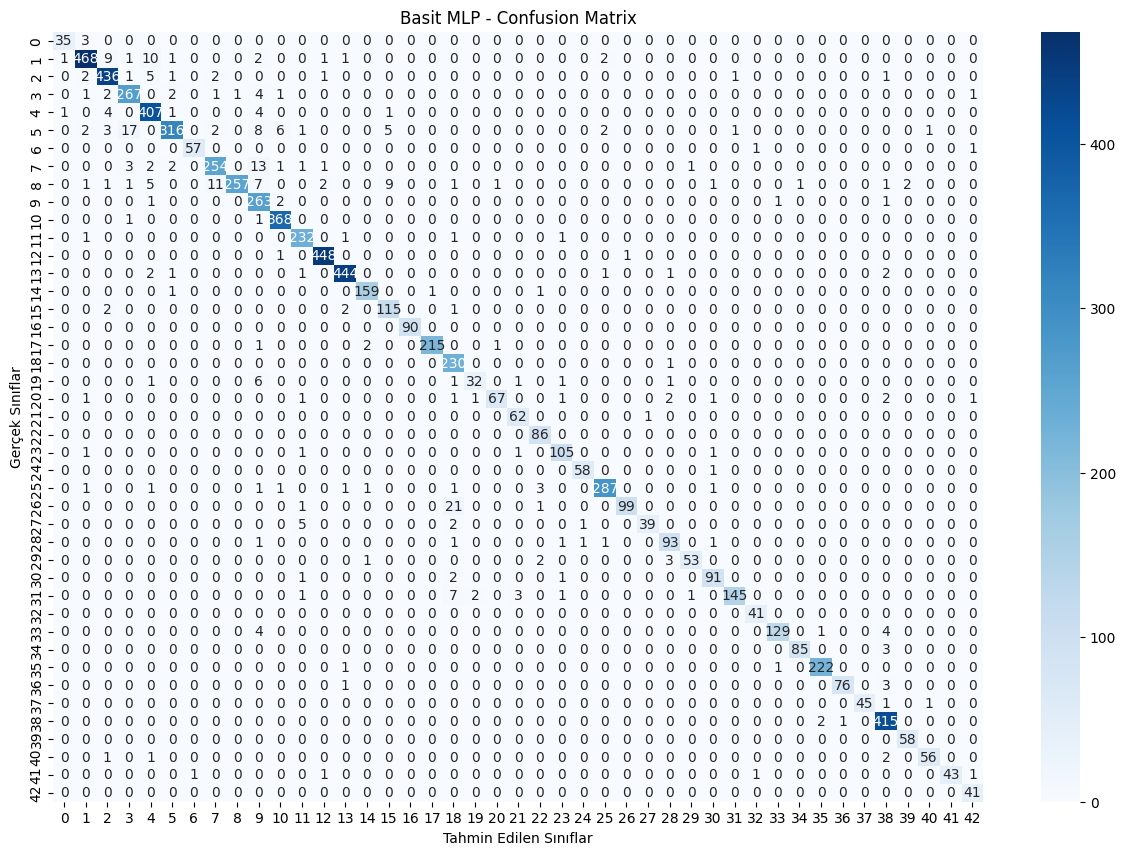


2. Her Sınıf için Detaylı Metrikler:
          Precision    Recall  F1-Score  Support
Sınıf 0    0.945946  0.921053  0.933333     38.0
Sınıf 1    0.972973  0.943548  0.958035    496.0
Sınıf 2    0.951965  0.968889  0.960352    450.0
Sınıf 3    0.917526  0.953571  0.935201    280.0
Sınıf 4    0.935632  0.973684  0.954279    418.0
Sınıf 5    0.972308  0.868132  0.917271    364.0
Sınıf 6    0.982759  0.966102  0.974359     59.0
Sınıf 7    0.940741  0.913669  0.927007    278.0
Sınıf 8    0.996124  0.853821  0.919499    301.0
Sınıf 9    0.834921  0.981343  0.902230    268.0
Sınıf 10   0.968421  0.994595  0.981333    370.0
Sınıf 11   0.946939  0.983051  0.964657    236.0
Sınıf 12   0.986784  0.995556  0.991150    450.0
Sınıf 13   0.984479  0.982301  0.983389    452.0
Sınıf 14   0.975460  0.981481  0.978462    162.0
Sınıf 15   0.884615  0.958333  0.920000    120.0
Sınıf 16   1.000000  1.000000  1.000000     90.0
Sınıf 17   0.995370  0.981735  0.988506    219.0
Sınıf 18   0.855019  0.995671  

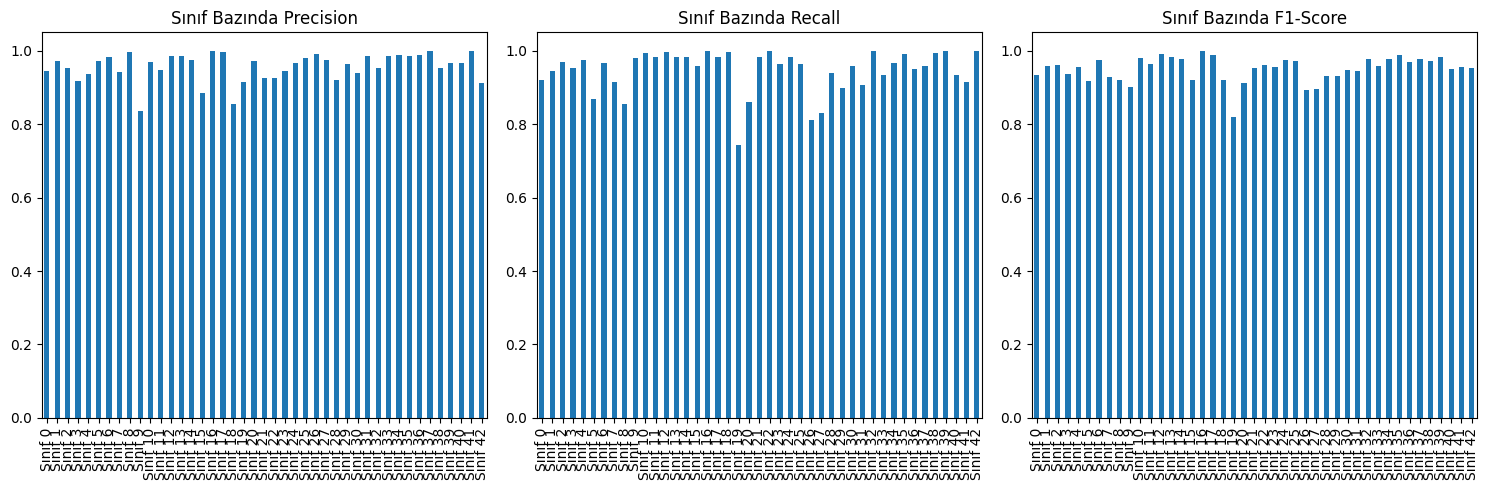


4. En İyi ve En Kötü Performans Gösteren Sınıflar:

En İyi 5 Sınıf (F1-Score):
Sınıf 16    1.000000
Sınıf 12    0.991150
Sınıf 35    0.988864
Sınıf 17    0.988506
Sınıf 13    0.983389
Name: F1-Score, dtype: float64

En Kötü 5 Sınıf (F1-Score):
Sınıf 19    0.820513
Sınıf 26    0.891892
Sınıf 27    0.896552
Sınıf 9     0.902230
Sınıf 20    0.911565
Name: F1-Score, dtype: float64


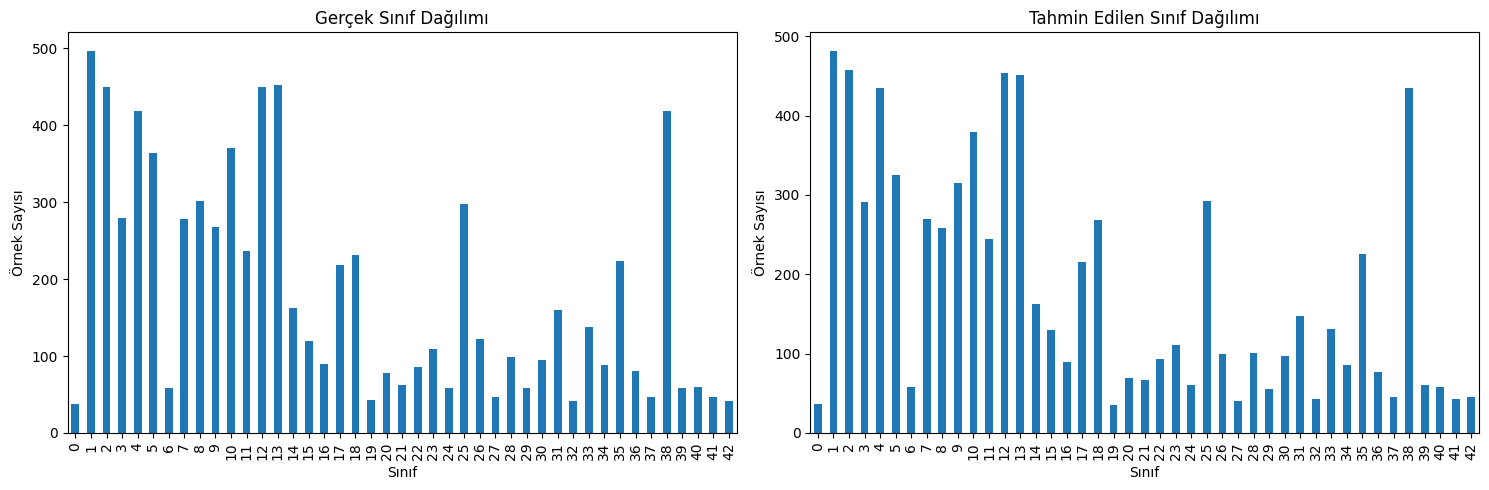


Basit RBF eğitimi...
Model Özeti:


Model: "functional_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_26 (InputLayer)          │ (None, 3072)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_75               │ (None, 3072)                │          12,288 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rbf_layer_26 (RBFLayer)              │ (None, 256)                 │         786,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_75 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_77 (Dense)                     │ (None, 512)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_76               │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_76 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_78 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_77               │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_77 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_79 (Dense)                     │ (None, 43)                  │          11,051 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,075,755 (4.10 MB)

 Trainable params: 1,068,075 (4.07 MB)

 Non-trainable params: 7,680 (30.00 KB)

Epoch 1/100
393/393 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.0494 - loss: 3.6230 - val_accuracy: 0.0561 - val_loss: 3.4918
Epoch 2/100
393/393 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0561 - loss: 3.5026 - val_accuracy: 0.0583 - val_loss: 3.4921
Epoch 3/100
393/393 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0650 - loss: 3.4741 - val_accuracy: 0.0870 - val_loss: 3.4899
Epoch 4/100
393/393 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1031 - loss: 3.2908 - val_accuracy: 0.1089 - val_loss: 3.7864
Epoch 5/100
393/393 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1858 - loss: 2.8983 - val_accuracy: 0.2710 - val_loss: 2.5044
Epoch 6/100
393/393 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2846 - loss: 2.4337 - val_accuracy: 0.3805 - val_loss: 2.0469
Epoch 7/100
393/393 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3579 - loss: 2.1223 - val_accuracy: 0.5300 - val_loss: 1.6542
Epoch 8/100
393/393 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4054 - loss: 1.9591 - val_ac

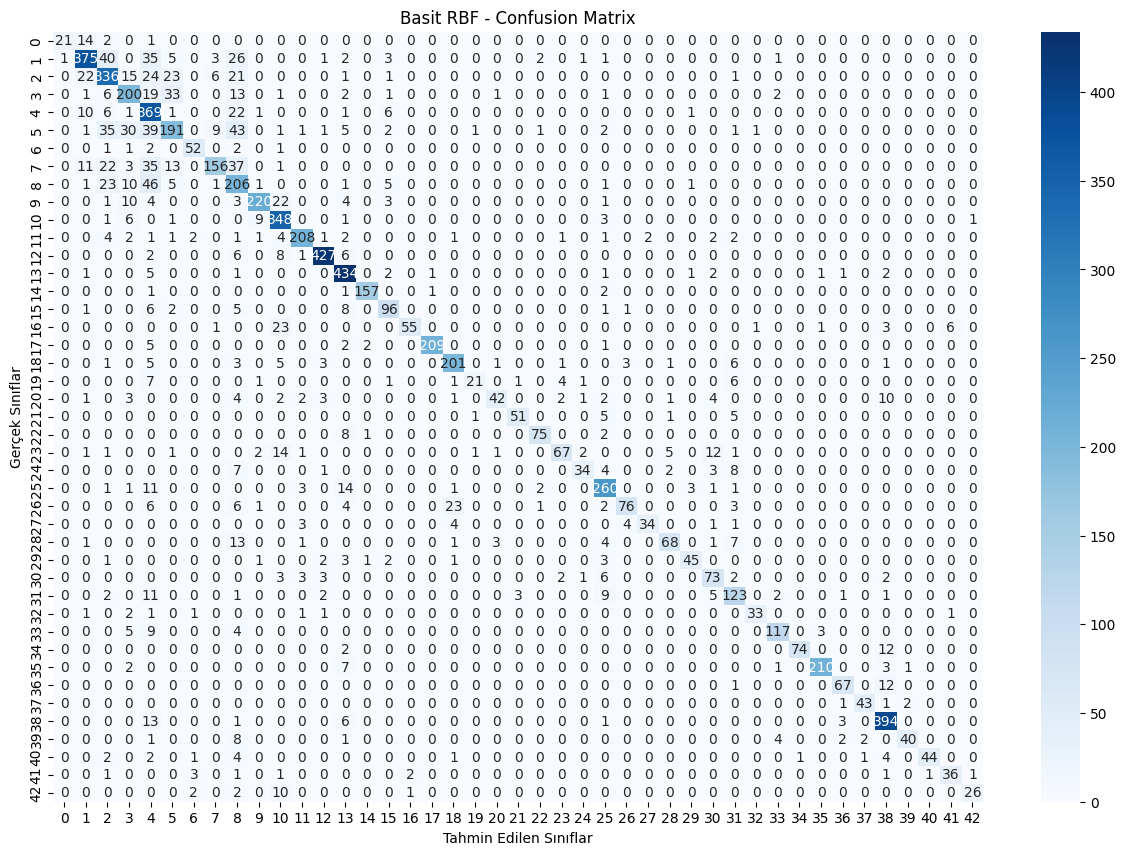


2. Her Sınıf için Detaylı Metrikler:
          Precision    Recall  F1-Score  Support
Sınıf 0    0.954545  0.552632  0.700000     38.0
Sınıf 1    0.850340  0.756048  0.800427    496.0
Sınıf 2    0.691358  0.746667  0.717949    450.0
Sınıf 3    0.687285  0.714286  0.700525    280.0
Sınıf 4    0.559091  0.882775  0.684601    418.0
Sınıf 5    0.692029  0.524725  0.596875    364.0
Sınıf 6    0.852459  0.881356  0.866667     59.0
Sınıf 7    0.886364  0.561151  0.687225    278.0
Sınıf 8    0.468182  0.684385  0.556005    301.0
Sınıf 9    0.928270  0.820896  0.871287    268.0
Sınıf 10   0.783784  0.940541  0.855037    370.0
Sınıf 11   0.928571  0.881356  0.904348    236.0
Sınıf 12   0.959551  0.948889  0.954190    450.0
Sınıf 13   0.842718  0.960177  0.897622    452.0
Sınıf 14   0.975155  0.969136  0.972136    162.0
Sınıf 15   0.786885  0.800000  0.793388    120.0
Sınıf 16   0.948276  0.611111  0.743243     90.0
Sınıf 17   0.990521  0.954338  0.972093    219.0
Sınıf 18   0.855319  0.870130  

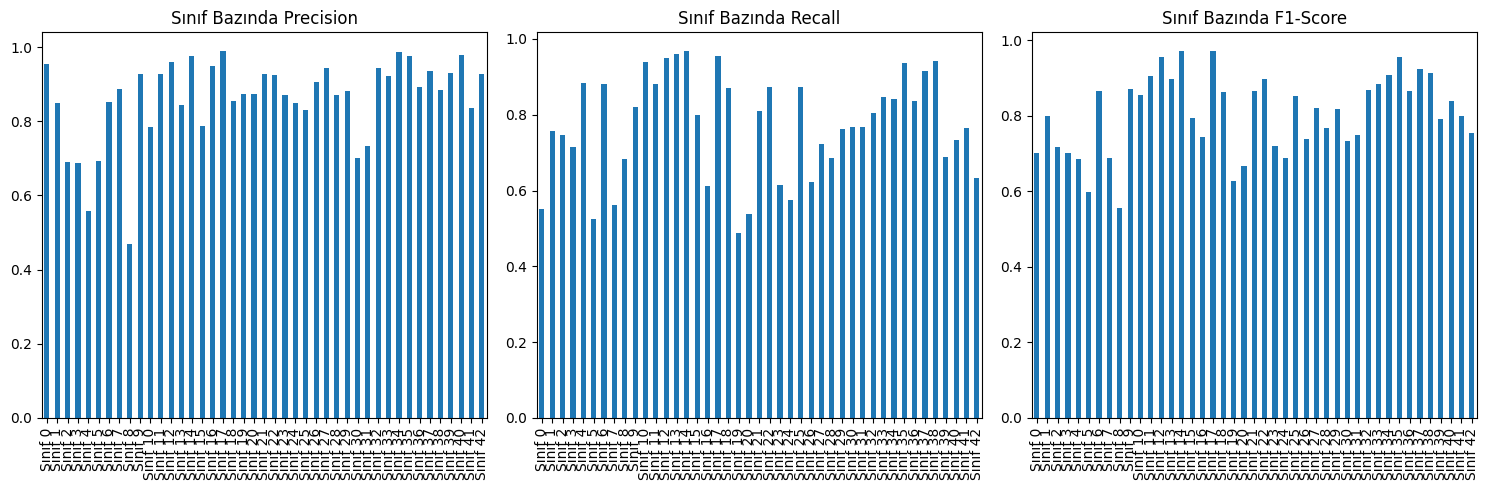


4. En İyi ve En Kötü Performans Gösteren Sınıflar:

En İyi 5 Sınıf (F1-Score):
Sınıf 14    0.972136
Sınıf 17    0.972093
Sınıf 35    0.956720
Sınıf 12    0.954190
Sınıf 37    0.924731
Name: F1-Score, dtype: float64

En Kötü 5 Sınıf (F1-Score):
Sınıf 8     0.556005
Sınıf 5     0.596875
Sınıf 19    0.626866
Sınıf 20    0.666667
Sınıf 4     0.684601
Name: F1-Score, dtype: float64


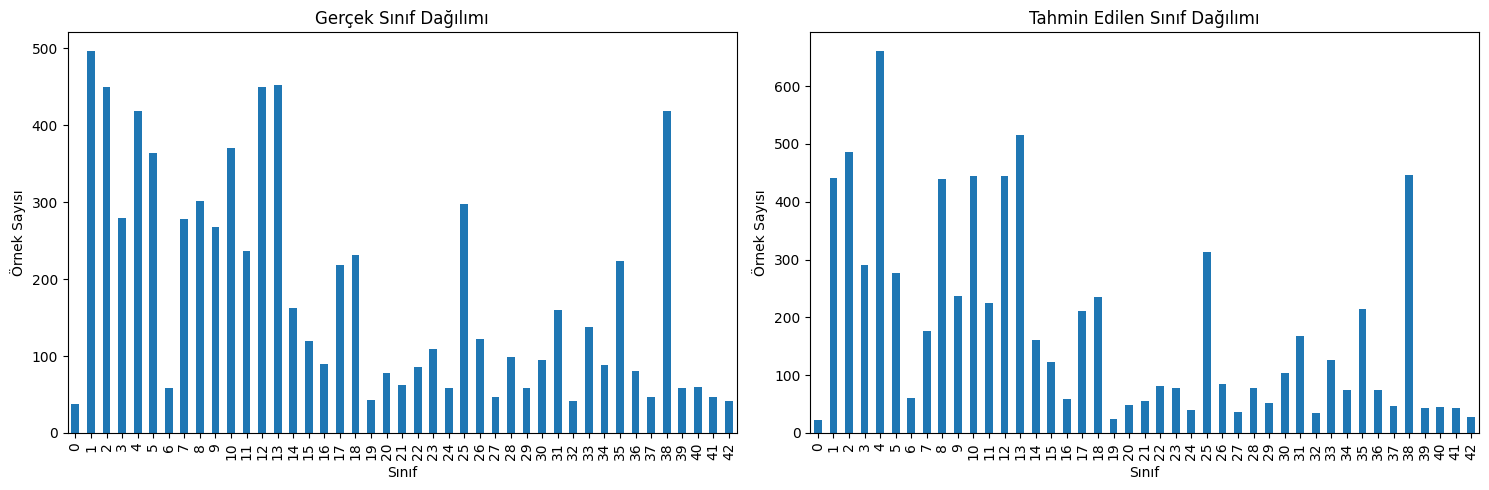


3. Hiperparametre optimizasyonu...

MLP hiperparametre optimizasyonu...
Fitting 3 folds for each of 10 candidates, totalling 30 fits

Optimize Edilmiş MLP için Detaylı Performans Analizi

1. Temel Metrikler:
              precision    recall  f1-score   support

           0       0.97      0.89      0.93        38
           1       0.97      0.95      0.96       496
           2       0.97      0.96      0.96       450
           3       0.95      0.86      0.90       280
           4       0.97      0.97      0.97       418
           5       0.75      0.97      0.85       364
           6       0.95      0.97      0.96        59
           7       0.93      0.92      0.92       278
           8       0.98      0.88      0.93       301
           9       0.97      0.91      0.94       268
          10       0.98      0.99      0.99       370
          11       0.94      0.97      0.96       236
          12       1.00      0.98      0.99       450
          13       0.99      0.98 

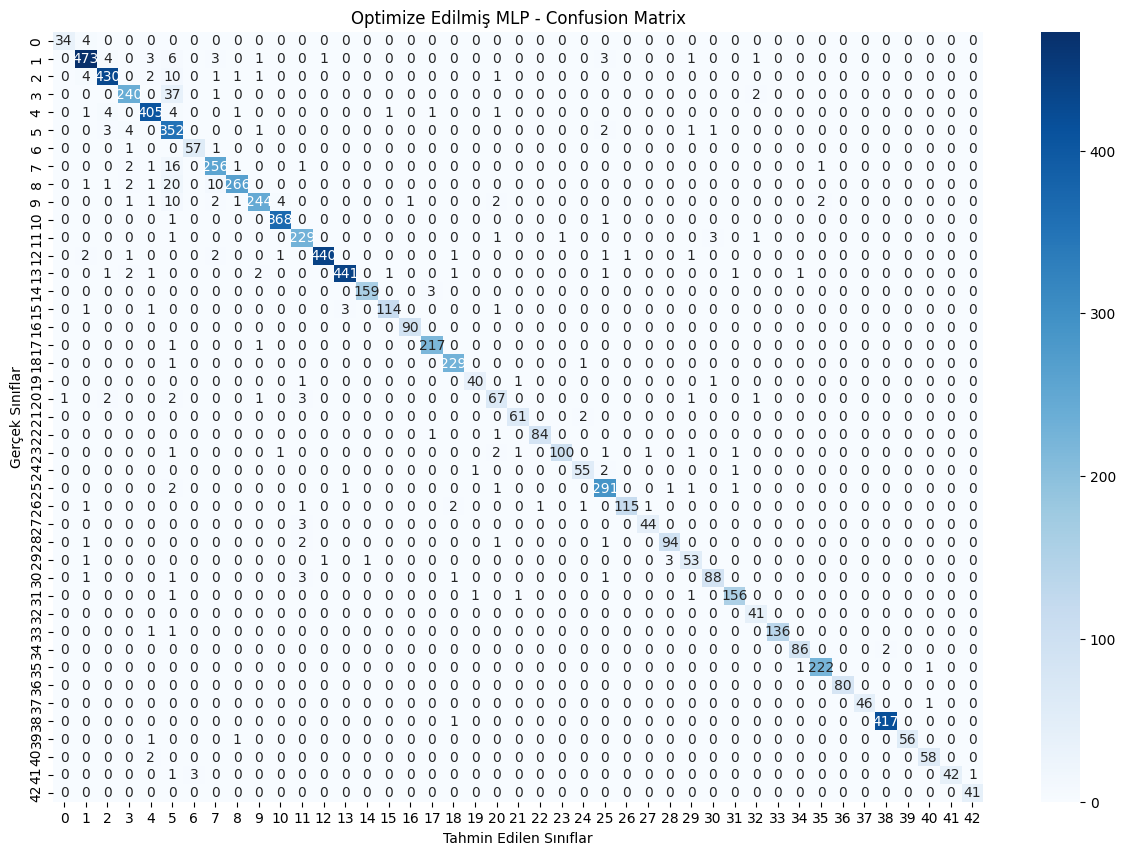


2. Her Sınıf için Detaylı Metrikler:
          Precision    Recall  F1-Score  Support
Sınıf 0    0.971429  0.894737  0.931507     38.0
Sınıf 1    0.965306  0.953629  0.959432    496.0
Sınıf 2    0.966292  0.955556  0.960894    450.0
Sınıf 3    0.948617  0.857143  0.900563    280.0
Sınıf 4    0.966587  0.968900  0.967742    418.0
Sınıf 5    0.752137  0.967033  0.846154    364.0
Sınıf 6    0.950000  0.966102  0.957983     59.0
Sınıf 7    0.927536  0.920863  0.924188    278.0
Sınıf 8    0.981550  0.883721  0.930070    301.0
Sınıf 9    0.972112  0.910448  0.940270    268.0
Sınıf 10   0.983957  0.994595  0.989247    370.0
Sınıf 11   0.942387  0.970339  0.956159    236.0
Sınıf 12   0.995475  0.977778  0.986547    450.0
Sınıf 13   0.991011  0.975664  0.983278    452.0
Sınıf 14   0.993750  0.981481  0.987578    162.0
Sınıf 15   0.982759  0.950000  0.966102    120.0
Sınıf 16   0.989011  1.000000  0.994475     90.0
Sınıf 17   0.977477  0.990868  0.984127    219.0
Sınıf 18   0.974468  0.991342  

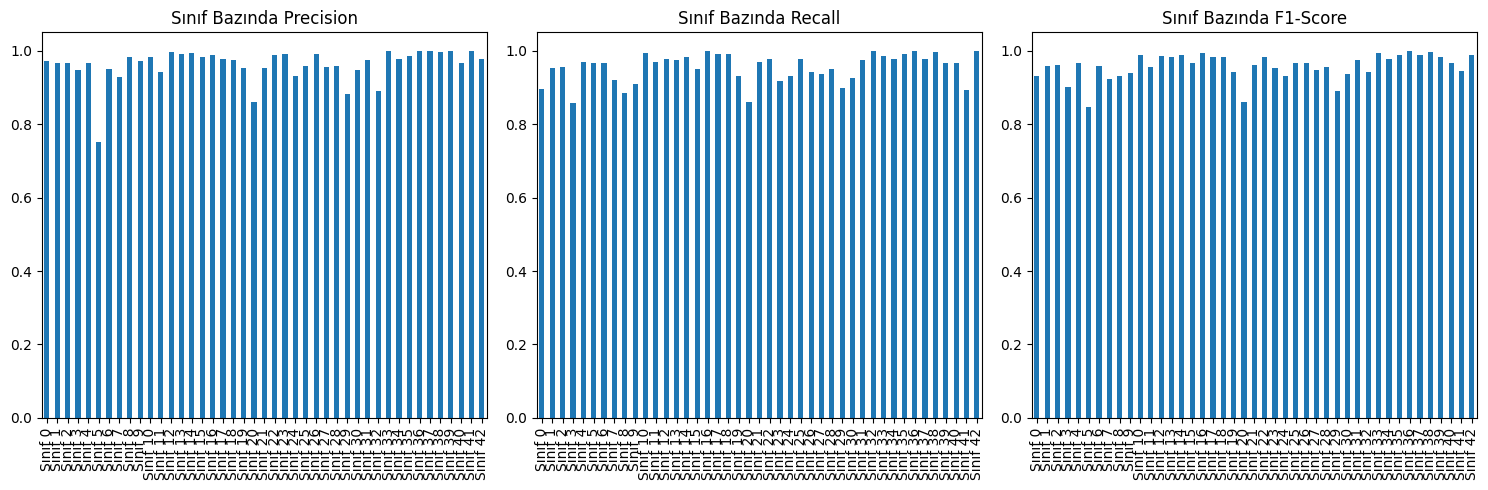


4. En İyi ve En Kötü Performans Gösteren Sınıflar:

En İyi 5 Sınıf (F1-Score):
Sınıf 36    1.000000
Sınıf 38    0.996416
Sınıf 16    0.994475
Sınıf 33    0.992701
Sınıf 10    0.989247
Name: F1-Score, dtype: float64

En Kötü 5 Sınıf (F1-Score):
Sınıf 5     0.846154
Sınıf 20    0.858974
Sınıf 29    0.890756
Sınıf 3     0.900563
Sınıf 7     0.924188
Name: F1-Score, dtype: float64


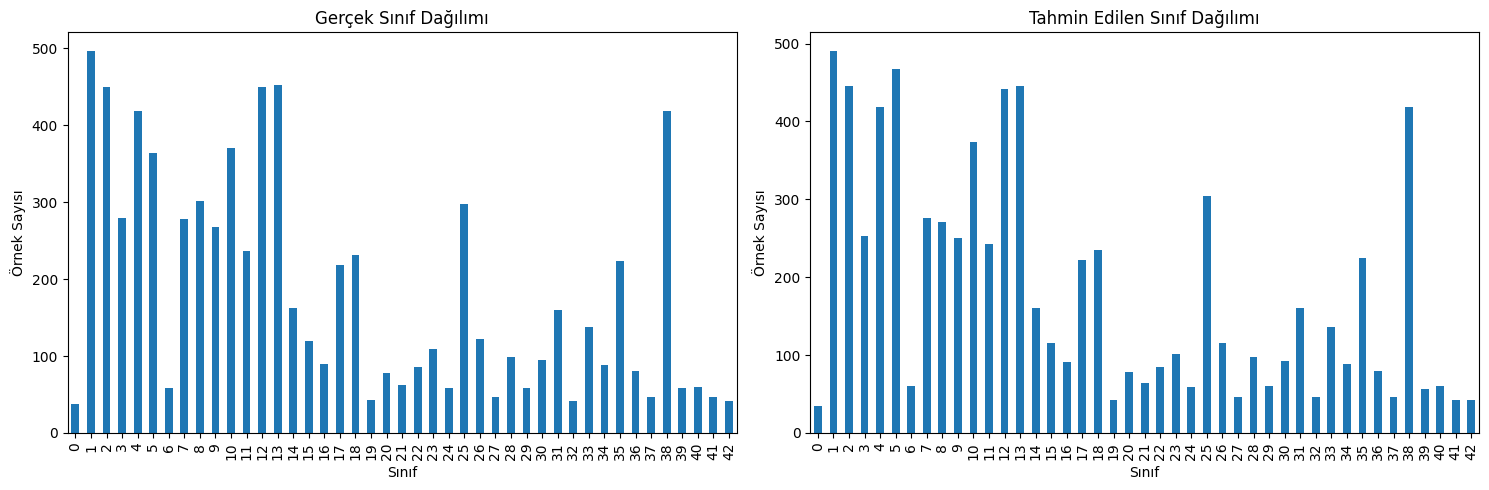


RBF hiperparametre optimizasyonu...

RBF test: centers=128, gamma=0.001
Epoch 1/100
785/785 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.0655 - loss: 3.5660 - val_accuracy: 0.0826 - val_loss: 3.3968
Epoch 2/100
785/785 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.0946 - loss: 3.3403 - val_accuracy: 0.1221 - val_loss: 3.2559
Epoch 3/100
785/785 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.1450 - loss: 3.1658 - val_accuracy: 0.1957 - val_loss: 2.9962
Epoch 4/100
785/785 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.2149 - loss: 2.9229 - val_accuracy: 0.2381 - val_loss: 2.7417
Epoch 5/100
785/785 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.2652 - loss: 2.6683 - val_accuracy: 0.3114 - val_loss: 2.5110
Epoch 6/100
785/785 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.3143 - loss: 2.4687 - val_accuracy: 0.3617 - val_loss: 2.3035
Epoch 7/100
785/785 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.3594 - loss: 2.3006 - val_accuracy: 0.4082 - val_loss: 2.1784
Epoch 8/100
785/785 ━━━

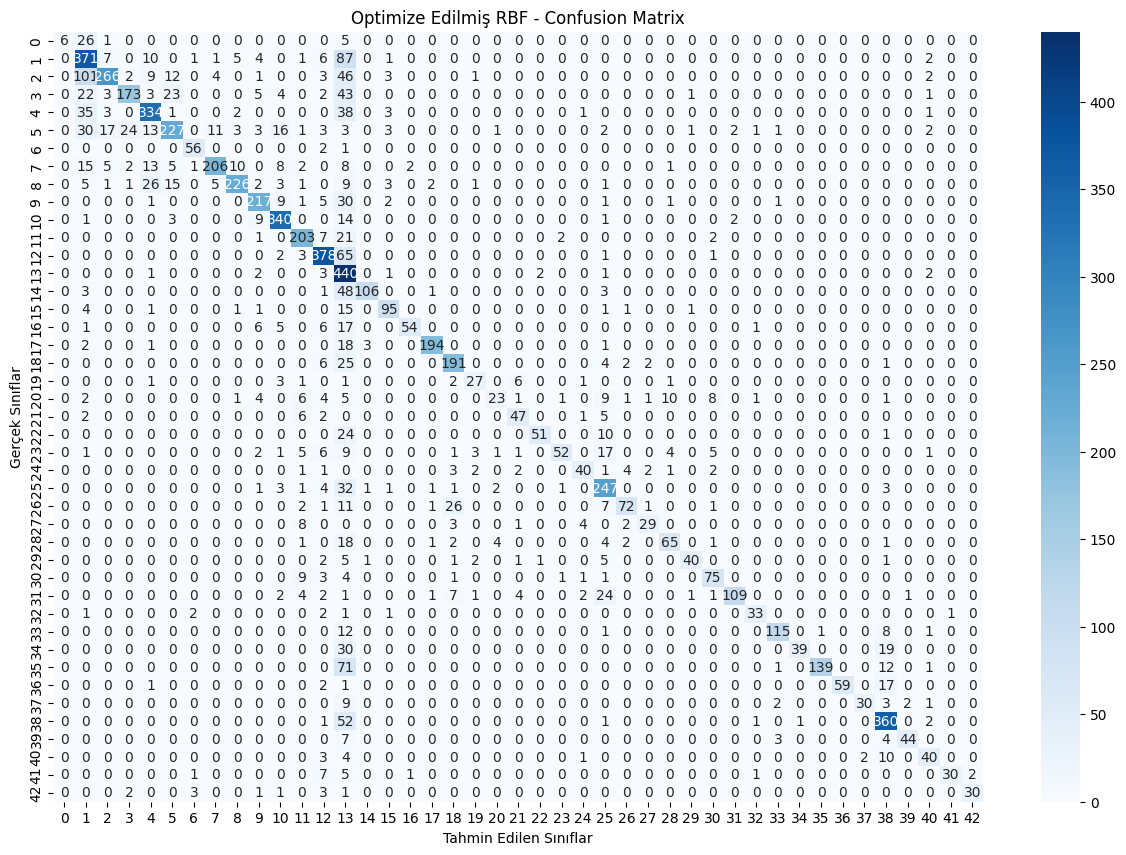


2. Her Sınıf için Detaylı Metrikler:
          Precision    Recall  F1-Score  Support
Sınıf 0    1.000000  0.157895  0.272727     38.0
Sınıf 1    0.596463  0.747984  0.663685    496.0
Sınıf 2    0.877888  0.591111  0.706507    450.0
Sınıf 3    0.848039  0.617857  0.714876    280.0
Sınıf 4    0.806763  0.799043  0.802885    418.0
Sınıf 5    0.793706  0.623626  0.698462    364.0
Sınıf 6    0.875000  0.949153  0.910569     59.0
Sınıf 7    0.907489  0.741007  0.815842    278.0
Sınıf 8    0.911290  0.750831  0.823315    301.0
Sınıf 9    0.837838  0.809701  0.823529    268.0
Sınıf 10   0.856423  0.918919  0.886571    370.0
Sınıf 11   0.792969  0.860169  0.825203    236.0
Sınıf 12   0.812903  0.840000  0.826230    450.0
Sınıf 13   0.355987  0.973451  0.521327    452.0
Sınıf 14   0.954955  0.654321  0.776557    162.0
Sınıf 15   0.840708  0.791667  0.815451    120.0
Sınıf 16   0.947368  0.600000  0.734694     90.0
Sınıf 17   0.965174  0.885845  0.923810    219.0
Sınıf 18   0.802521  0.826840  

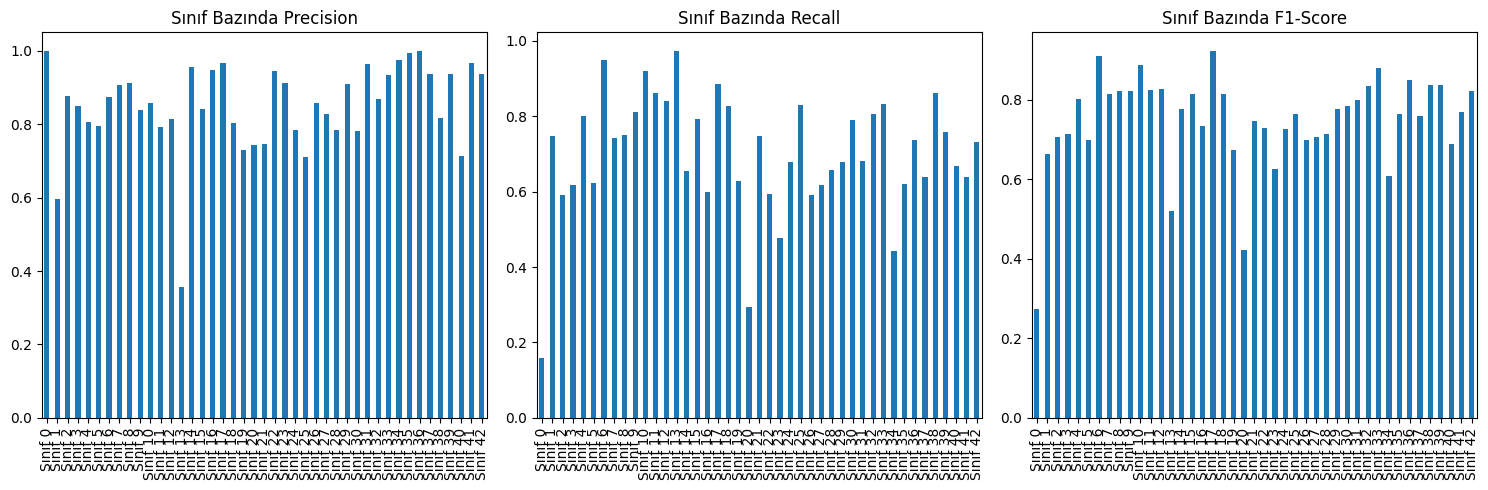


4. En İyi ve En Kötü Performans Gösteren Sınıflar:

En İyi 5 Sınıf (F1-Score):
Sınıf 17    0.923810
Sınıf 6     0.910569
Sınıf 10    0.886571
Sınıf 33    0.881226
Sınıf 36    0.848921
Name: F1-Score, dtype: float64

En Kötü 5 Sınıf (F1-Score):
Sınıf 0     0.272727
Sınıf 20    0.422018
Sınıf 13    0.521327
Sınıf 34    0.609375
Sınıf 23    0.626506
Name: F1-Score, dtype: float64


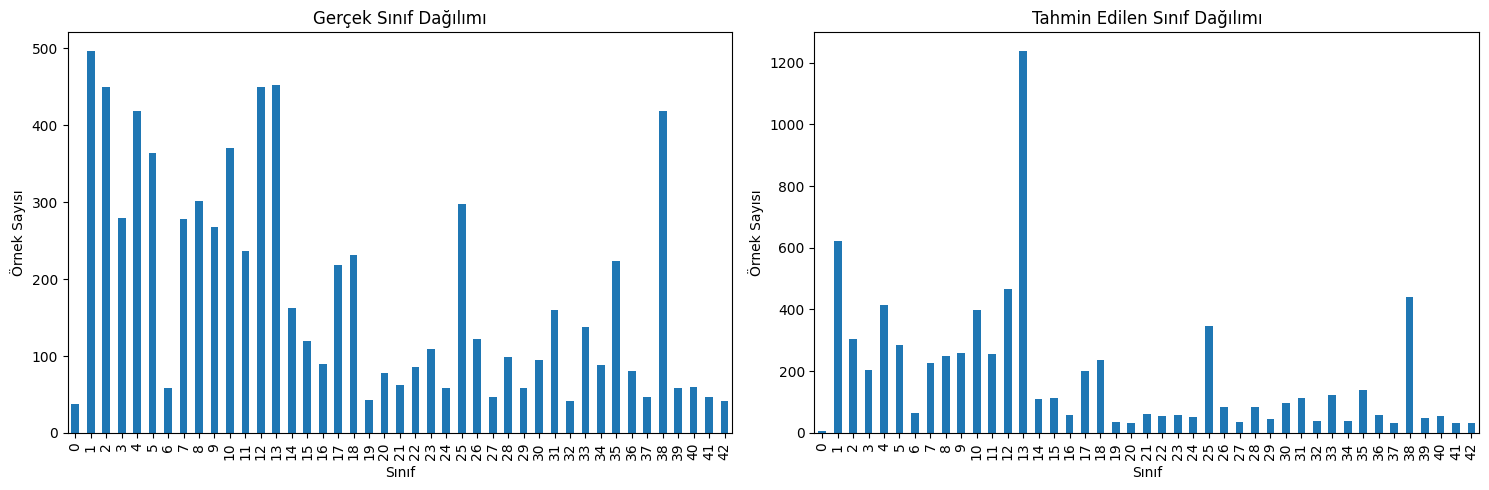


Final Karşılaştırma Tablosu:
          Model  Accuracy  Macro F1-Score  Weighted F1-Score  Macro Precision  \
0     Basit MLP    0.9550          0.9502             0.9548           0.9569   
1     Basit RBF    0.8052          0.8042             0.8062           0.8615   
2  Optimize MLP    0.9586          0.9577             0.9591           0.9621   
3  Optimize RBF    0.7497          0.7484             0.7587           0.8502   

   Macro Recall  
0        0.9464  
1        0.7701  
2        0.9548  
3        0.7007  


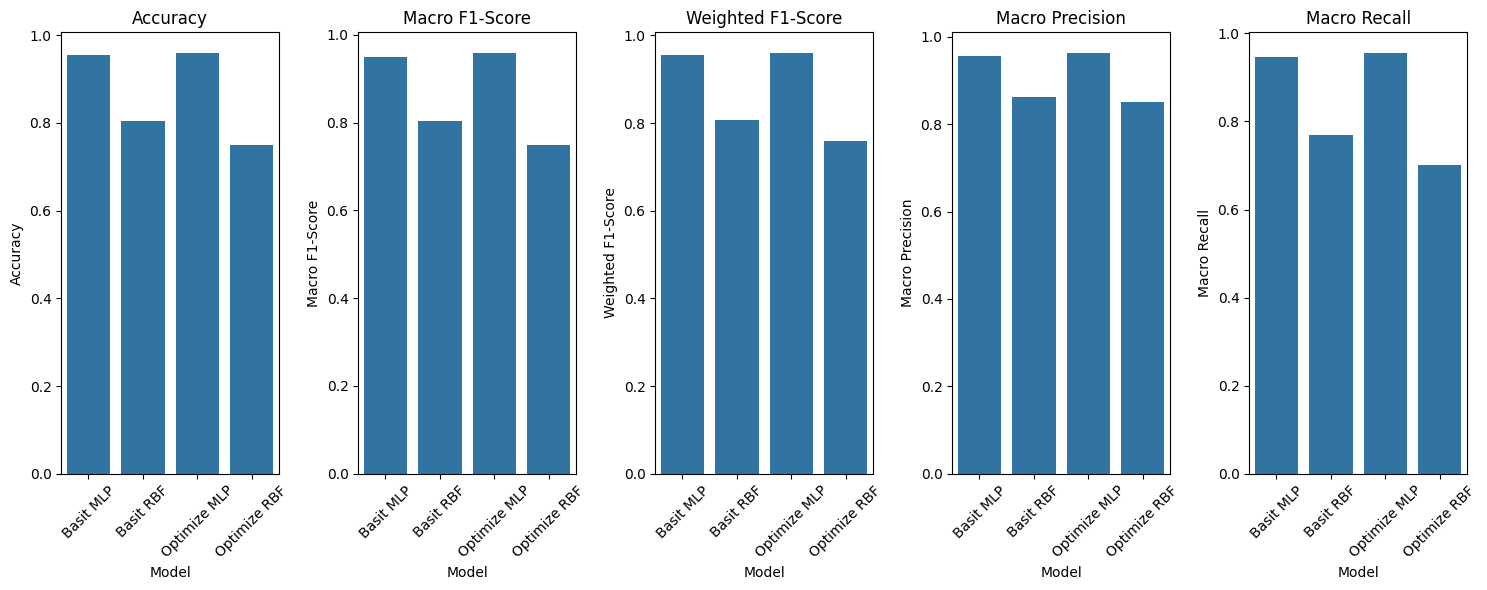

In [ ]:

# Ana program
try:
    # 1. Veri yükleme ve ön işleme
    print("1. Veri yükleme ve ön işleme...")
    X, y = load_data()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # 2. Basit modellerin eğitimi
    print("\n2. Basit modellerin eğitimi...")

    # Basit MLP
    print("\nBasit MLP eğitimi...")
    basic_mlp = create_basic_mlp()
    basic_mlp.fit(X_train_scaled, y_train)
    basic_mlp_pred = basic_mlp.predict(X_test_scaled)
    basic_mlp_metrics = detailed_evaluation(y_test, basic_mlp_pred, "Basit MLP")

    # Modeli çağırırken:
    print("\nBasit RBF eğitimi...")
    basic_rbf = create_basic_rbf_model(
        input_dim=X_train.shape[1],
        num_classes=43,
        num_centers=256,  # Merkez sayısını artırdık
        gamma=0.005      # Gamma değerini düşürdük
    )

    # Early stopping ve model checkpoint ekleyelim
    early_stopping = keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    )

    # Model eğitimi
    basic_rbf_history = basic_rbf.fit(
        X_train_scaled, y_train,
        epochs=100,  # Epoch sayısını artırdık
        batch_size=64,  # Batch size'ı artırdık
        validation_split=0.2,
        callbacks=[early_stopping],
        verbose=1
    )

    basic_rbf_pred = np.argmax(basic_rbf.predict(X_test_scaled), axis=1)
    basic_rbf_metrics = detailed_evaluation(y_test, basic_rbf_pred, "Basit RBF")

    # 3. Hiperparametre optimizasyonu
    print("\n3. Hiperparametre optimizasyonu...")

    # MLP için
    print("\nMLP hiperparametre optimizasyonu...")
    mlp_param_dist = {
        'hidden_layer_sizes': [(100,), (100, 50), (100, 100), (150, 100), (200, 150)],
        'activation': ['relu', 'tanh'],
        'learning_rate_init': [0.001, 0.01, 0.0001],
        'batch_size': [32, 64, 128]
    }

    mlp_random = RandomizedSearchCV(
        MLPClassifier(max_iter=300, random_state=42),
        param_distributions=mlp_param_dist,
        n_iter=10,
        cv=3,
        n_jobs=-1,
        verbose=2,
        scoring='f1_weighted'
    )

    mlp_results = mlp_random.fit(X_train_scaled, y_train)
    opt_mlp_pred = mlp_random.predict(X_test_scaled)
    opt_mlp_metrics = detailed_evaluation(y_test, opt_mlp_pred, "Optimize Edilmiş MLP")

        # RBF için hiperparametre optimizasyonu
    print("\nRBF hiperparametre optimizasyonu...")
    rbf_params = {
        'num_centers': [128, 256],
        'gamma': [0.001, 0.01, 0.1]  # Gamma değerlerini daha geniş bir aralıkta deniyoruz
    }

    best_rbf_score = 0
    best_rbf_params = None
    best_rbf_model = None

    for centers in rbf_params['num_centers']:
        for gamma in rbf_params['gamma']:
            print(f"\nRBF test: centers={centers}, gamma={gamma}")

            # Model oluşturma
            rbf_model = keras.Sequential([
                keras.layers.Input(shape=(X_train.shape[1],)),
                RBFLayer(centers, gamma),
                Dense(512, activation='relu'),
                keras.layers.BatchNormalization(),
                Dense(256, activation='relu'),
                Dense(43, activation='softmax')
            ])

            # Model derleme
            rbf_model.compile(
                optimizer=keras.optimizers.Adam(learning_rate=0.0001),  # Learning rate'i düşürdük
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy']
            )

            # Early stopping ekle
            early_stopping = keras.callbacks.EarlyStopping(
                monitor='val_accuracy',
                patience=5,
                restore_best_weights=True
            )

            # Modeli eğit
            history = rbf_model.fit(
                X_train_scaled,
                y_train,
                epochs=100,
                batch_size=32,
                validation_split=0.2,
                callbacks=[early_stopping],
                verbose=1
            )

            # Validasyon setindeki en iyi accuracy
            val_acc = max(history.history['val_accuracy'])

            # Tahminleri kontrol et
            predictions = np.argmax(rbf_model.predict(X_test_scaled), axis=1)
            unique_classes = len(np.unique(predictions))

            print(f"Validasyon accuracy: {val_acc:.4f}")
            print(f"Tahmin edilen benzersiz sınıf sayısı: {unique_classes}")

            # Eğer model tüm sınıfları tahmin edebiliyorsa ve accuracy daha iyiyse
            if unique_classes > 1 and val_acc > best_rbf_score:
                best_rbf_score = val_acc
                best_rbf_params = {'num_centers': centers, 'gamma': gamma}
                best_rbf_model = rbf_model
                print("Yeni en iyi model kaydedildi!")

    print("\nEn iyi RBF parametreleri:", best_rbf_params)

    if best_rbf_model is None:
        print("Hiçbir model yeterli performans gösteremedi!")
    else:
        # En iyi modeli kullanarak tahminler yap
        opt_rbf_pred = np.argmax(best_rbf_model.predict(X_test_scaled), axis=1)
        unique_predictions = len(np.unique(opt_rbf_pred))
        print(f"Final modelin tahmin ettiği benzersiz sınıf sayısı: {unique_predictions}")
        opt_rbf_metrics = detailed_evaluation(y_test, opt_rbf_pred, "Optimize Edilmiş RBF")

    # 4. Final karşılaştırma
    final_comparison = pd.DataFrame({
        'Model': ['Basit MLP', 'Basit RBF', 'Optimize MLP', 'Optimize RBF'],
        'Accuracy': [
            basic_mlp_metrics['accuracy'],
            basic_rbf_metrics['accuracy'],
            opt_mlp_metrics['accuracy'],
            opt_rbf_metrics['accuracy']
        ],
        'Macro F1-Score': [
            basic_mlp_metrics['macro avg']['f1-score'],
            basic_rbf_metrics['macro avg']['f1-score'],
            opt_mlp_metrics['macro avg']['f1-score'],
            opt_rbf_metrics['macro avg']['f1-score']
        ],
        'Weighted F1-Score': [
            basic_mlp_metrics['weighted avg']['f1-score'],
            basic_rbf_metrics['weighted avg']['f1-score'],
            opt_mlp_metrics['weighted avg']['f1-score'],
            opt_rbf_metrics['weighted avg']['f1-score']
        ],
        'Macro Precision': [
            basic_mlp_metrics['macro avg']['precision'],
            basic_rbf_metrics['macro avg']['precision'],
            opt_mlp_metrics['macro avg']['precision'],
            opt_rbf_metrics['macro avg']['precision']
        ],
        'Macro Recall': [
            basic_mlp_metrics['macro avg']['recall'],
            basic_rbf_metrics['macro avg']['recall'],
            opt_mlp_metrics['macro avg']['recall'],
            opt_rbf_metrics['macro avg']['recall']
        ]
    })

    print("\nFinal Karşılaştırma Tablosu:")
    print(final_comparison.round(4))

    # Karşılaştırma grafiği
    plt.figure(figsize=(15, 6))
    metrics = ['Accuracy', 'Macro F1-Score', 'Weighted F1-Score', 'Macro Precision', 'Macro Recall']

    for i, metric in enumerate(metrics, 1):
        plt.subplot(1, 5, i)
        sns.barplot(data=final_comparison, x='Model', y=metric)
        plt.xticks(rotation=45)
        plt.title(metric)

    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"Bir hata oluştu: {str(e)}")